# Compare Classifiers
Included so far:
- SVM
- LSTM
- Gradient Boost
- AdaBoost
- Random Forest
- KNN

In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning_data_generation import loadOnlineEEGdata

D:\Masterthesis\thesis_eeg\code


Using TensorFlow backend.


In [2]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(splitData=True)
eegX_train, eegy_train, eegX_test, eegy_test = eegData
freqX_train, freqy_train, freqX_test, freqy_test = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
freqX_train = freqX_train.reshape(freqX_train.shape[0], freqX_train.shape[2])
freqX_test = freqX_test.reshape(freqX_test.shape[0], freqX_test.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])

Loading Online EEG Data from D:/Masterthesis/EEG_Data/eeg_data_online ...
EEG Data Shape:
(5024, 512, 40) (5024,) (2154, 512, 40) (2154,)
Freq Data Shape:
(1008, 1, 1200) (1008,) (432, 1, 1200) (432,)
Entropy Data Shape:
(5024, 1, 200) (5024,) (2154, 1, 200) (2154,)


In [3]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)  

### Create Models

In [4]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

randomState = 42
modelList = []

# LSTM - takes a lot of time...
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#modelList.append(("LSTM", "predict_proba", KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)))

# Gradient Boost
modelList.append(("Gradient Boost", "decision_function", GradientBoostingClassifier()))

# AdaBoost
modelList.append(("Ada Boost", "decision_function", AdaBoostClassifier()))

# SVM
modelList.append(("SVM", "decision_function", svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=randomState, shrinking=True,
  tol=0.001, verbose=False)))

# Random Forest
#modelList.append(("Random Forest", "predict_proba", RandomForestClassifier(n_estimators=100, random_state=randomState)))

# KNN
#modelList.append(("KNN", "predict_proba", KNeighborsClassifier(n_neighbors=3)))




In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

def evaluteModelsWithRocCurve(modelList, X, y, kFoldTimes=5):
    print("X shape: {}".format(X.shape))
    print("y shape: {}".format(y.shape))
    
    n_timesteps, n_features, n_outputs = 1, X.shape[1], 2
    plt.figure(figsize=(8, 6))

    for modelName, method, model in modelList:

        try:
            if modelName == "LSTM":
                y_predict = cross_val_predict(model, X.reshape(X.shape[0], 1, X.shape[1]), y, cv=kFoldTimes, method=method, n_jobs=-1)
            else:
                y_predict = cross_val_predict(model, X, y, cv=kFoldTimes, method=method, n_jobs=-1)



            if method == 'predict_proba':
                y_scores = y_predict[:, 1] # score = proba of positive class
                fpr, tpr, thresholds = roc_curve(y, y_scores)

            elif method == 'decision_function':
                fpr, tpr, thresholds = roc_curve(y, y_predict)

            else:
                print("Method '' not supported yet!".format(method))

            plot_roc_curve(fpr, tpr, modelName)
        except Exception as e:
            print ("Error with model: {}".format(modelName))
            raise(e)

    plt.grid(True)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

X shape: (5024, 200)
y shape: (5024,)


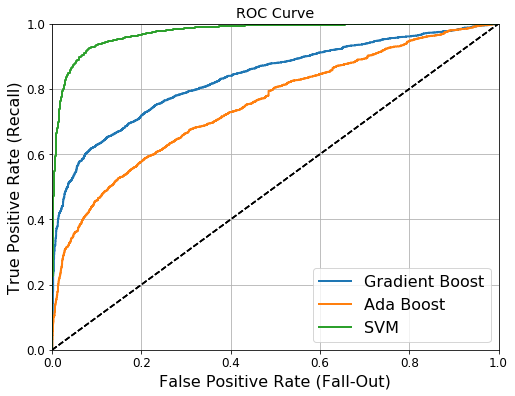

In [15]:
evaluteModelsWithRocCurve(modelList, X=X_train_entropy, y=y_train_entropy, kFoldTimes=6)